# Objective

In [1]:
# CNNs w SIFT instead of pooling: 
# https://arxiv.org/ftp/arxiv/papers/1904/1904.00197.pdf
# https://github.com/hmorimitsu/sift-flow-gpu

#### Colab Helpers (if needed)

In [2]:
# from google.colab import drive
# drive.mount("/content/gdrive")
# # drive.mount("/content/gdrive", force_remount=True)

In [3]:
# import os
# os.chdir("/content/gdrive/My Drive/...pathtocode")

In [4]:
# import torch
# a = torch.Tensor([1]).cuda()
# print(a)

## Load Fashion-MNIST and Net

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import copy

In [6]:
from utils.data_process import get_FASHION_data

TRAIN_IMAGES = 50000
VAL_IMAGES = 10000
TEST_IMAGES = 10000

data = get_FASHION_data(TRAIN_IMAGES, VAL_IMAGES, TEST_IMAGES)
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots


# For auto-reloading external modules
# See http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [7]:
# from models.neural_net_simple import NeuralNet
from models.neural_net_traditional import NeuralNet
# from models.neural_net_sift import NeuralNet

## Init Net and Train

In [8]:
# Hyperparameters
input_size = 28 * 28
num_classes = 10
epochs = 15 # 50 # 5 # 100
batch_size = 200
learning_rate = 0.001

# Initialize a new neural network model
net = NeuralNet(learning_rate,input_size,num_classes)


# # extract output of layers
# https://discuss.pytorch.org/t/how-can-i-extract-intermediate-layer-output-from-loaded-cnn-model/77301/3
# https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
    
activation = {}
def get_activation(name):
    def hook(net, input, output):
        activation[name] = output.detach()
    return hook

# net.layers[2].register_forward_hook(get_activation('pre_fc')) # for net_simple
net.layers[3].register_forward_hook(get_activation('pre_fc')) # for net_simple

# output = net(x)
# activation['fc2']

In [9]:
TRAIN_IMAGES = 50000
VAL_IMAGES = 10000
TEST_IMAGES = 10000

data = get_FASHION_data(TRAIN_IMAGES, VAL_IMAGES, TEST_IMAGES)
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']

# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32)
# X_val = torch.tensor(X_val, dtype=torch.float32)
# y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32)


# Variables to store performance for each epoch
train_loss = np.zeros(epochs)
train_accuracy = np.zeros(epochs)
val_accuracy = np.zeros(epochs)

start_time = time.time()
print('Running ',epochs,' epochs')

for epoch in range(epochs):
    print('epoch:', epoch)
    
    # Shuffle the dataset
    # data[['X','y']].sample(frac = 1)
    perm = np.random.permutation(X_train.shape[0])
    np.take(X_train,perm,axis=0,out=X_train)
    np.take(y_train,perm,axis=0,out=y_train)
    
    # Training
    # For each mini-batch...
    for batch in range(TRAIN_IMAGES // batch_size):
        # Create a mini-batch of training data and labels
        X_batch = X_train[batch*batch_size : batch*batch_size + batch_size, :]
        y_batch = y_train[batch*batch_size : batch*batch_size + batch_size]
        
        X_batch = torch.tensor(X_batch, dtype=torch.float32)
        y_batch = torch.tensor(y_batch, dtype=torch.float32)

        # Run the forward pass of the model to get a prediction and compute the accuracy
        forward_out = net.forward(X_batch).detach().numpy()
        pred_labels = np.argmax(forward_out,axis=1)
        train_accuracy[epoch] += sum(pred_labels == np.asarray(y_batch)) / batch_size

        # Run the backward pass of the model to compute the loss, and update the weights
        y_batch_for_L = y_batch.type(torch.LongTensor)
        loss = net.backward(X_batch,y_batch_for_L)
        train_loss[epoch] += loss

    # normalize
    train_accuracy[epoch] /= (TRAIN_IMAGES // batch_size)
    train_loss[epoch] /= (TRAIN_IMAGES // batch_size)

    # Validation
    # No need to run the backward pass here, just run the forward pass to compute accuracy
    X_val = torch.tensor(X_val, dtype=torch.float32)
    val_forward_out = net.forward(X_val).detach().numpy()
    val_pred_labels = np.argmax(val_forward_out,axis=1)
    val_accuracy[epoch] += sum(val_pred_labels == np.asarray(y_val)) / len(y_val)
    
    net.epoch += 1
    

print('Done. Time:',time.time()-start_time)

Running  15  epochs
epoch: 0
epoch: 1


<ipython-input-9-5650785be3ea>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32)


epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
Done. Time: 2302.406450033188


In [28]:
# torch.save(net.state_dict(), 'trad_15epoch.pth')

In [ ]:
# model.load_state_dict(torch.load('trad_15epoch.pth'))
# model.eval()

## Graph loss and train/val accuracies

train_accuracy[-1]: 0.39654
val_accuracy[-1]:   0.3929


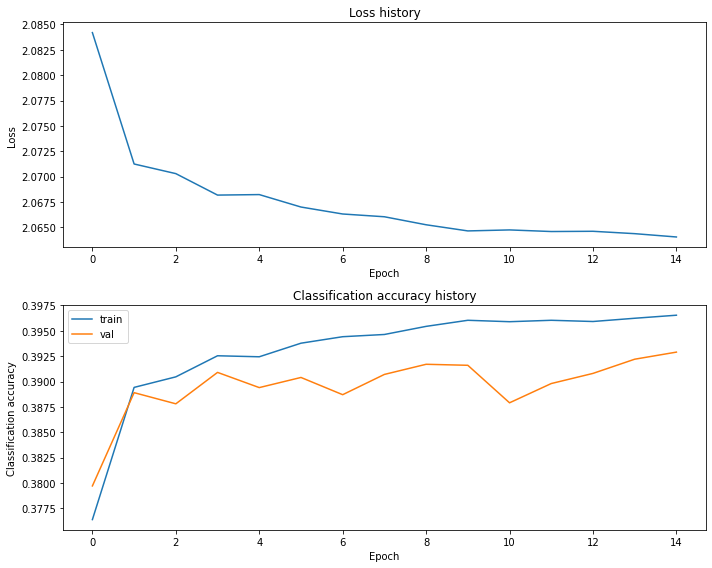

In [27]:
print('train_accuracy[-1]:',train_accuracy[-1])
print('val_accuracy[-1]:  ',val_accuracy[-1])

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(train_loss)
# plt.plot(train_loss[:49])
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='val')
# plt.plot(train_accuracy[:49], label='train')
# plt.plot(val_accuracy[:49], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()

plt.tight_layout()
# plt.savefig('loss_acc_trad_5epoch.jpg',dpi=1000)
# plt.savefig('loss_acc_trad_15epoch.jpg',dpi=1000)
plt.show()

In [23]:
print(train_loss)
print(train_accuracy)

[2.08419569 2.07124253 2.07029266 2.0681762  2.06822606 2.06699937
 2.06631254 2.06603961 2.06525007 2.06464363 2.06474215 2.06458379
 2.06460716 2.06437369 2.064046  ]
[0.37638 0.38942 0.39046 0.39254 0.39244 0.39378 0.39442 0.39464 0.39544
 0.39604 0.3959  0.39604 0.39592 0.39624 0.39654]


## Run on Test Set, Visualize Features


In [24]:
from sklearn.manifold import TSNE

In [25]:
# # TSNE
# https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
# https://builtin.com/data-science/tsne-python

In [26]:
# run test set
out = net(X_test)
pred = np.argmax(out.detach().numpy(),axis=1)
print('Accuracy:', sum(pred == np.asarray(y_test)) / len(y_test) )

# look at output of layer
data = activation['pre_fc']
labels = y_test

# np.save('data_prefc_trad_5epoch.npy',data)
np.save('data_prefc_trad_15epoch.npy',data)

print(data.shape)
# print(data[0])

Accuracy: 0.3946
torch.Size([10000, 64, 12, 12])


In [15]:
# choose random subset of points to visualize
num_data_vis = 3000 # 50 #10
np.random.seed(42) # For reproducability

rndperm = np.random.permutation(data.shape[0])[:num_data_vis]

data_sel = data[rndperm, :].reshape(num_data_vis,-1)
labels_sel = labels[rndperm]

print(data_sel.shape, labels_sel.shape)

torch.Size([3000, 9216]) (3000,)


In [16]:
time_start = time.time()
# # could increase perplexity and n_iter
tsne = TSNE(n_components=2, verbose=1, perplexity=15, n_iter=300)

tsne_results = tsne.fit_transform(data_sel)
print('tsne_results.shape',tsne_results.shape)

print('t-SNE done. Time elapsed: {} seconds'.format(time.time()-time_start))
# Time::  50: <1, 3000: 2.3sec

/home/james/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/james/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.012s...
[t-SNE] Computed neighbors for 3000 samples in 3.373s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 227.572190
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.364975
[t-SNE] KL divergence after 300 iterations: 1.877447
tsne_results.shape (3000, 2)
t-SNE done. Time elapsed: 5.886410713195801 seconds


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


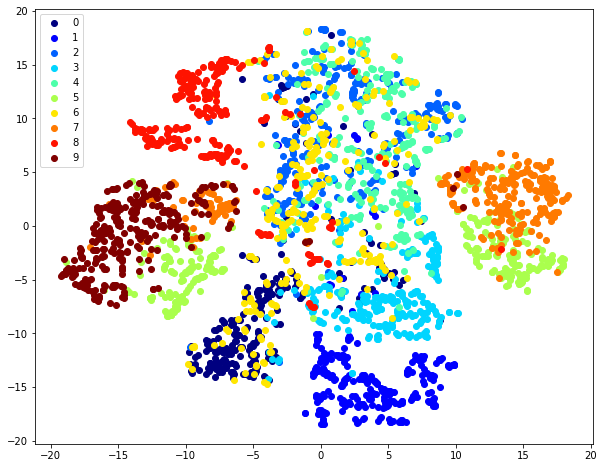

In [17]:
# display results

x_plot = tsne_results[:,0]
y_plot = tsne_results[:,1]

# https://stackoverflow.com/questions/42056713/matplotlib-scatterplot-with-legend
unique = list(set(labels_sel))
print(unique)
colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
for i, u in enumerate(unique):
    xi = [x_plot[j] for j  in range(len(x_plot)) if labels_sel[j] == u]
    yi = [y_plot[j] for j  in range(len(y_plot)) if labels_sel[j] == u]
    plt.scatter(xi, yi, color=colors[i], label=str(u))
plt.legend()
# plt.savefig('Simple_model_vis_fc2.jpg',dpi=1000)
# plt.savefig('vis_trad_5epoch.jpg',dpi=1000)
plt.savefig('vis_trad_15epoch.jpg',dpi=1000)

## Compare Reg Model and SIFT model
Create graphs to compare training loss and validation accuracy

In [18]:
# # TODO

In [19]:
# create new model
# incorporate this sift descriptor written in pytorch
# it is written on gpu though so idk, to work out

# https://github.com/hmorimitsu/sift-flow-gpu

In [20]:
# train new model

# test on test set

In [21]:
# compare classifications

# # Plot the loss function and train / validation accuracies
# plt.subplot(2, 1, 1)
# # print(train_loss)
# plt.plot(train_loss, label='SGD')

# plt.plot(train_loss_adam, label='Adam')
# # plt.plot(train_loss[:49])
# plt.title('Loss history')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(train_accuracy, label='train SGD')
# plt.plot(val_accuracy, label='val SGD')
# plt.plot(train_accuracy_adam, label='train Adam')
# plt.plot(val_accuracy_adam, label='val Adam')
# # plt.plot(train_accuracy[:49], label='train')
# # plt.plot(val_accuracy[:49], label='val')
# plt.title('Classification accuracy history')
# plt.xlabel('Epoch')
# plt.ylabel('Classification accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()